# PINNs-Based 1D Acoustic Wave Simulation with a Source Term

This notebook presents a neural network aproximation reinforced with PINNs to the solution for the homogeneous 1D elastic wave equation

\begin{equation}
\rho \partial_t^2 u(x,t) =  \mu\partial_x^2 u(x,t) + f(x,t),
\end{equation}


where:

- $ \rho $ is the constant density of the medium (in kg/m³).
- $ u(x,t) $ (in m) is the displacement field, which depends on position $ x $ (in m) and time $ t $ (in s).
- $ \partial_t^2 $ is the second derivative with respect to time, representing acceleration (in 1/s²).
- $ \mu $ is the constant shear modulus, which measures the material's resistance to shear stress (in Pa or N/m² or kg/(m·s²)).
- $ \partial_x^2 $ is the second derivative with respect to position $ x $ (in 1/m²).
- $ f(x,t) $ is the external force applied, which depends on position $ x $ (in m) and time $ t $ (in s), and has units of force density (in N/m³ or kg/(m²s²)).


In the following code block, we import the necessary libraries for our notebook. This includes NumPy for numerical operations, PyTorch for building and training the neural network, Matplotlib for plotting, a utility module for additional plotting functions, and the time module for timing our training process.

In [1]:
# Import libraries for numerical operations
import numpy as np

# Import libraries for random operations and data serialization
import random
import pickle

# Import PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim

# Import libraries for data visualization
import matplotlib.pyplot as plt
from utils_plots import *  # utility module for additional plotting functions

# Import libraries for utility functions
import time  # to time our training process
from scipy.interpolate import griddata  # for data interpolation

# Configure warnings
import warnings
warnings.filterwarnings("ignore")  # Ignore warning messages

In the following code block, we load the data obteined from a spectral elements implemented in the notebook W9_se_homo_1d_solution.ipynb with modified input parameters of the course [computers, waves, simulations](https://www.coursera.org/learn/computers-waves-simulations).

The following parameters were chosen for the simulation:

- A density ($\rho$) of 2200 kg/m³.
- The shear modulus, denoted by $\mu$, calculated as the product of density ($\rho$ = 2200 kg/m³) and the square of the S-wave velocity ($v_{s}$ = 2500 m/s), resulting in 13.75 $\times 10^{9}$ kg/(m·s²).
- The $x$ domain is set to [0, 1000] (m).
- The $t$ domain is set to [0, 0.15] (s).

The result of the simulation is loaded  in the following cell. Where `t_grid` contain the $t$ domain values, `x_grid` the $x$ domain values and `u_grid` the displacement field.

In [2]:
# Open the file containing the data
with open('data/4_se_data.pkl', 'rb') as f:
    # Load the data from the file
    # t_grid, x_grid, and u_grid are expected to be in the file
    t_grid, x_grid, u_grid = pickle.load(f)

# Convert the loaded data to NumPy arrays for easier manipulation
# This step is necessary if the loaded data is not already in NumPy array format
x_grid = np.array(x_grid)  # Grid of x values
t_grid = np.array(t_grid)  # Grid of t (time) values
u_grid = np.array(u_grid)  # Grid of u (wave amplitude) values

This cell generates a new grid of 10,000 points, arranged in a 100x100 matrix, by interpolating the original `x_grid`, `t_grid`, and `u_grid` values using a 'linear' method. It also identifies any `NaN` values present in the interpolated data and replaces them with the nearest non-`NaN` values. In this grid, `x` represents the horizontal axis and `t` represents the vertical axis. This preprocessing of the data is performed to reduce the time required for neural network training.

In [3]:
# Define the number of points for the new grid
num_points = 500

# Create a new grid of points
# The range of the grid is determined by the minimum and maximum values of the original grids
x_new = np.linspace(np.nanmin(x_grid), np.nanmax(x_grid), num_points)
t_new = np.linspace(np.nanmin(t_grid), np.nanmax(t_grid), num_points)

# Create a meshgrid using the new x and t values
x_grid_new, t_grid_new = np.meshgrid(x_new, t_new)

# Prepare the data for interpolation
# The original x and t grids are flattened and stacked vertically
# The u_grid is also flattened to match the shape
points = np.vstack((x_grid.flatten(), t_grid.flatten())).T
values = u_grid.flatten()

# Perform the interpolation using the 'nearest' method
u_grid_new = griddata(points, values, (x_grid_new, t_grid_new), method='linear')

# Identify the NaN values in the interpolated data
mask = np.isnan(u_grid_new)

# Replace the NaN values with the nearest non-NaN values
u_grid_new[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), u_grid_new[~mask])

# Update the original grids with the new grids
x_grid = x_grid_new
t_grid = t_grid_new
u_grid = u_grid_new

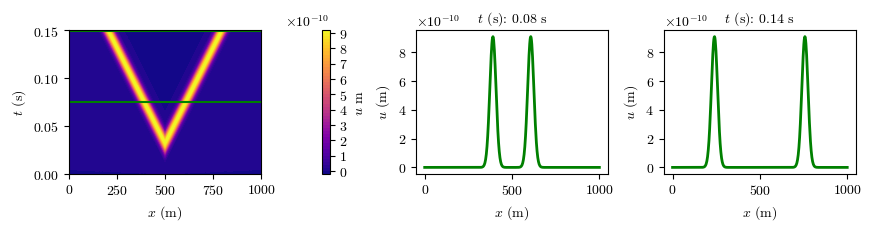

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(8.6, 2.2))

# First subplot
contourf_plot=axs[0].contourf(x_grid, t_grid, u_grid, origin='lower', extent=(0, 1, 0, 1), levels=50,cmap='plasma')
axs[0].set_xlabel('$x$ (m)')
axs[0].set_ylabel('$t$ (s)')
axs[0].axhline(np.max(t_grid)/2, color='green')
axs[0].axhline(t_grid[-5,0], color='green')
fig.colorbar(contourf_plot, ax=axs[0], label='$u$ m')

# Second subplot
axs[1].plot(x_grid[int(x_grid.shape[0]*0.5),:], u_grid[int(x_grid.shape[0]*0.5),:], color='green', linewidth=2)
axs[1].set_xlabel('$x$ (m)')
axs[1].set_ylabel('$u$ (m)')
axs[1].set_title("$t$ (s): {:.2f} s".format(t_grid[int(x_grid.shape[0]*0.5),0]),fontsize=10)

# Third subplot
axs[2].plot(x_grid[int(x_grid.shape[0]*0.9),:], u_grid[int(x_grid.shape[0]*0.9),:], color='green', linewidth=2)
axs[2].set_xlabel('$x$ (m)')
axs[2].set_ylabel('$u$ (m)')
axs[2].set_title("$t$ (s): {:.2f} s".format(t_grid[int(x_grid.shape[0]*0.9),0]),fontsize=10)

#fig.savefig('imgs/4_Normalized_Original_Data.png', format='png')

plt.show()

## Variable Scaling and Non-Dimensionalization

To scale the independent variables ($x$ and $t$) and dependent variables ($u$ and $f$) in equation 1, we need to introduce non-dimensional variables. We denote the characteristic length scale as L (which could be, for instance, the maximum length in the problem), the characteristic time scale as T (such as the maximum time in the problem), and the characteristic displacement and force as $U$ and $F$ respectively.

We define the non-dimensional variables as follows:

- $ x' = \frac{x}{L} $

- $ t' = \frac{t}{T} $

- $ u' = \frac{u}{U} $

- $ f' = \frac{f}{F} $

Substituting these into the equation 1 yields:

\begin{equation}\tag{2} \rho \frac{U}{T^2} \frac{\partial^2 u'}{\partial {t'}^2} = \mu \frac{U}{L^2} \frac{\partial^2 u'}{\partial {x'}^2} + F f'(x',t'). \end{equation}

This results in an equation where all variables have been non-dimensionalized. To simplify, we can define new parameters as follows:

- $\rho' = \rho \frac{U}{F T^2}$

- $\mu' = \mu \frac{U}{ F L^2}$

Substituting these into the equation 2, we get:

\begin{equation}\tag{3}
\rho'\frac{\partial^2 u'}{\partial {t'}^2} = \mu' \frac{\partial^2 u'}{\partial {x'}^2} +  f'(x',t').
\end{equation}

For the simulation considered in this notebook let's consider:

- U = $9.08 \times 10^{-9}$ m
- T = 0.15 s
- L = 1000 m



In [5]:
vs = 2500#torch.tensor(2500)  # S velocity [m/s] 
rho = 2200#torch.tensor(2200) # Density [kg/m^3]
mu = rho * vs**2#torch.tensor(rho * vs**2)  # Shear modulus mu

In [6]:
import numpy as np

# Convert numpy arrays to PyTorch tensors
u = torch.from_numpy(u_grid).float()
x = torch.from_numpy(x_grid).float()
t = torch.from_numpy(t_grid).float()

def finite_diff_second_order(u, h, axis):
    # Compute the second derivative of u with respect to x_or_t using finite differences
    u_x_or_t_plus = torch.roll(u, shifts=-1, dims=axis)
    u_x_or_t_minus = torch.roll(u, shifts=1, dims=axis)
    return (u_x_or_t_plus - 2*u + u_x_or_t_minus) / h**2

# Compute the grid spacing
hx = np.abs(x_grid[0,1] - x_grid[0,0])
ht = np.abs(t_grid[1,0] - t_grid[0,0])

dudx2 = finite_diff_second_order(u, hx, axis=1)  # axis=1 for x
dudt2 = finite_diff_second_order(u, ht, axis=0)  # axis=0 for t

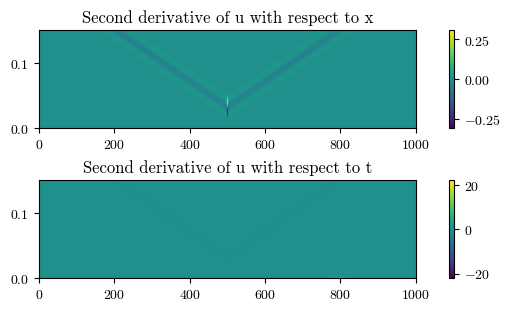

In [7]:
 
# Convert tensors to numpy arrays for plotting
dudx2_np = dudx2.detach().numpy().squeeze()
dudt2_np = dudt2.detach().numpy().squeeze()

# Create a figure and axes
fig, ax = plt.subplots(2, 1, figsize=(5, 3))

# Plot dudx2
c1 = ax[0].imshow(mu*dudx2_np, extent=[x_grid.min(), x_grid.max(), t_grid.min(), t_grid.max()], origin='lower', aspect='auto')
ax[0].set_title('Second derivative of u with respect to x')
fig.colorbar(c1, ax=ax[0])

# Plot dudt2
c2 = ax[1].imshow(rho*dudt2_np, extent=[x_grid.min(), x_grid.max(), t_grid.min(), t_grid.max()], origin='lower', aspect='auto')
ax[1].set_title('Second derivative of u with respect to t')
fig.colorbar(c2, ax=ax[1])

# Show the plots
#plt.tight_layout()
plt.show()

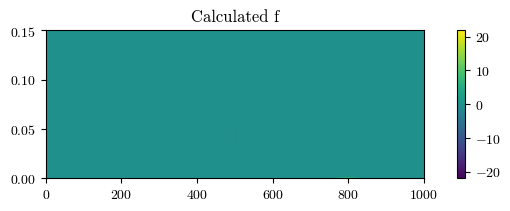

In [8]:
f = rho*dudt2_np - mu*dudx2_np  


# Create a figure and axes
fig, ax = plt.subplots(figsize=(5, 2))

# Plot f
c = ax.imshow(f, extent=[x_grid.min(), x_grid.max(), t_grid.min(), t_grid.max()], origin='lower', aspect='auto')
ax.set_title('Calculated f')
fig.colorbar(c, ax=ax)

# Show the plot
plt.show()

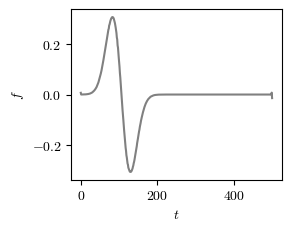

In [9]:
# figsize sets the width and height of the figure in inches
fig = plt.figure(figsize=(2.8, 2.2))

# Plot the u values as a function of t and x
plt.plot(np.array(f)[:,249], color='gray')#, origin='lower'

# Label the x and y axes
plt.xlabel('$t$')
plt.ylabel('$f$')

# Display the plot
plt.show()